In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
import scipy.io
import pandas as pd
from elephant.gpfa import GPFA
import numpy as np
import quantities as pq
import neo
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')

/opt/anaconda3/envs/elephant_env/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)


### Load gpfa data

In [3]:
with open('data/spikeTimes.pickle', 'rb') as filename:
    st = pickle.load(filename)
    
behav = pd.read_csv('data/RT_cue_choice.csv',header=None, names=['RT','cue','choice'])

In [4]:
# add a movement onset column
behav['mvmt'] = behav['RT'] + 400

In [5]:
behav.head()

,RT,cue,choice,mvmt
0,297,67,1,697
1,309,117,1,709
2,313,214,1,713
3,316,108,1,716
4,322,180,1,722


In [6]:
numTrials = len(st)
numNeurons = len(st[0])

### Raster Plot

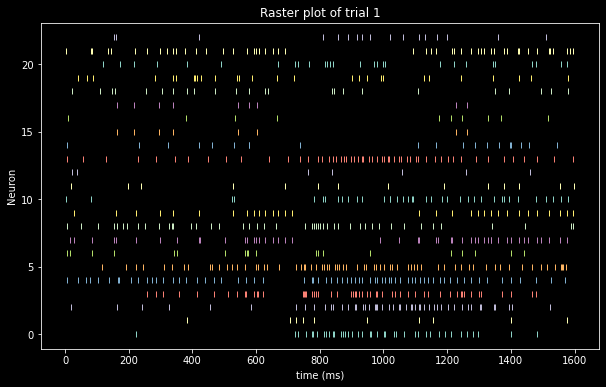

In [7]:
fig = plt.figure(figsize=(10,6))
for i, spiketrain in enumerate(st[0]):
    plt.plot(spiketrain, np.ones_like(spiketrain)*i, ls='', marker='|')

plt.title('Raster plot of trial 1')
plt.xlabel('time (ms)')
plt.ylabel('Neuron')
plt.show()

### Apply GPFA to all trials with 4 latent dimensions

In [8]:
# use a small number of trials for now
# st = st[:numTrials//20]
# numTrials = len(st)

In [9]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 4

gpfa = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [10]:
# gpfa.fit(st[:numTrials//2])
# print(gpfa.params_estimated.keys())

In [11]:
# trajectories = gpfa.transform(st[numTrials//2:])

In [12]:
# here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before

# trajectories_all = gpfa.fit_transform(st)

In [13]:
# trajectories_all_4d = trajectories_all
# with open('data/gpfa_trajectories_4d.pickle', 'wb') as filename:
#     pickle.dump(trajectories_all_4d, filename)

In [14]:
with open('data/gpfa_trajectories_4d.pickle', 'rb') as filename:
    trajectories_all = pickle.load(filename)

In [15]:
times_trajectory = np.arange(len(trajectories_all[0][0])) * bin_size.rescale('ms')

In [16]:
# get fast and slow trial idx for plotting
quantiles = behav['RT'].quantile([0.25,0.75])
fastRTs = behav[behav['RT'] <= quantiles[0.25]]
fastRTidx = list(fastRTs.index)
slowRTs = behav[behav['RT'] >= quantiles[0.75]]
slowRTidx = list(slowRTs.index)

In [17]:
# bin the trials by RT for plotting

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

nbins = 20 # actually 19
quantile_array = np.arange(1/nbins,1,1/nbins)
quantiles = behav['RT'].quantile(quantile_array)
trials_per_bin = {}
count = 1
for i in quantiles.index:
    if count==1:
        temp = behav[behav['RT'] <= quantiles[i]]
        trials_per_bin[i] = list(temp.index)
    elif count==len(quantiles):
        temp = behav[behav['RT'] >= quantiles[i]]
        trials_per_bin[i] = list(temp.index)
    else:
        t1 = list(behav[behav['RT'] >= quantiles[i]].index)
        t2 = list(behav[behav['RT'] <= quantiles[i]].index)
        trials_per_bin[i] = intersection(t1,t2)
    
    count += 1
    
# drop empty bins    
emptyBins = []
for q, dim in trials_per_bin.items():
    if dim == []:
        emptyBins.append(q)
        
for q in emptyBins:
    del trials_per_bin[q]

In [18]:
# for each bin of trials, compute average time to mvmt onset

def RT_idx(m):
    m = np.floor(m)
    for i in range(20):
        if m % 20 == 0:
            break
        m += 1
    try:
        t_idx = np.where(times_trajectory==m)[0][0]
    except:
        t_idx = len(times_trajectory)
    return t_idx

binMvmtIdx = {}
for q,trials in trials_per_bin.items():
    trialRTs = behav['mvmt'][trials]
    binMvmtIdx[q] = RT_idx(np.mean(trialRTs))

In [19]:
# average trials per bin
avg_traj = {}
for i in trials_per_bin.keys():
    avg_traj[i] = np.mean(trajectories_all[trials_per_bin[i]], axis=0)

### Plotting

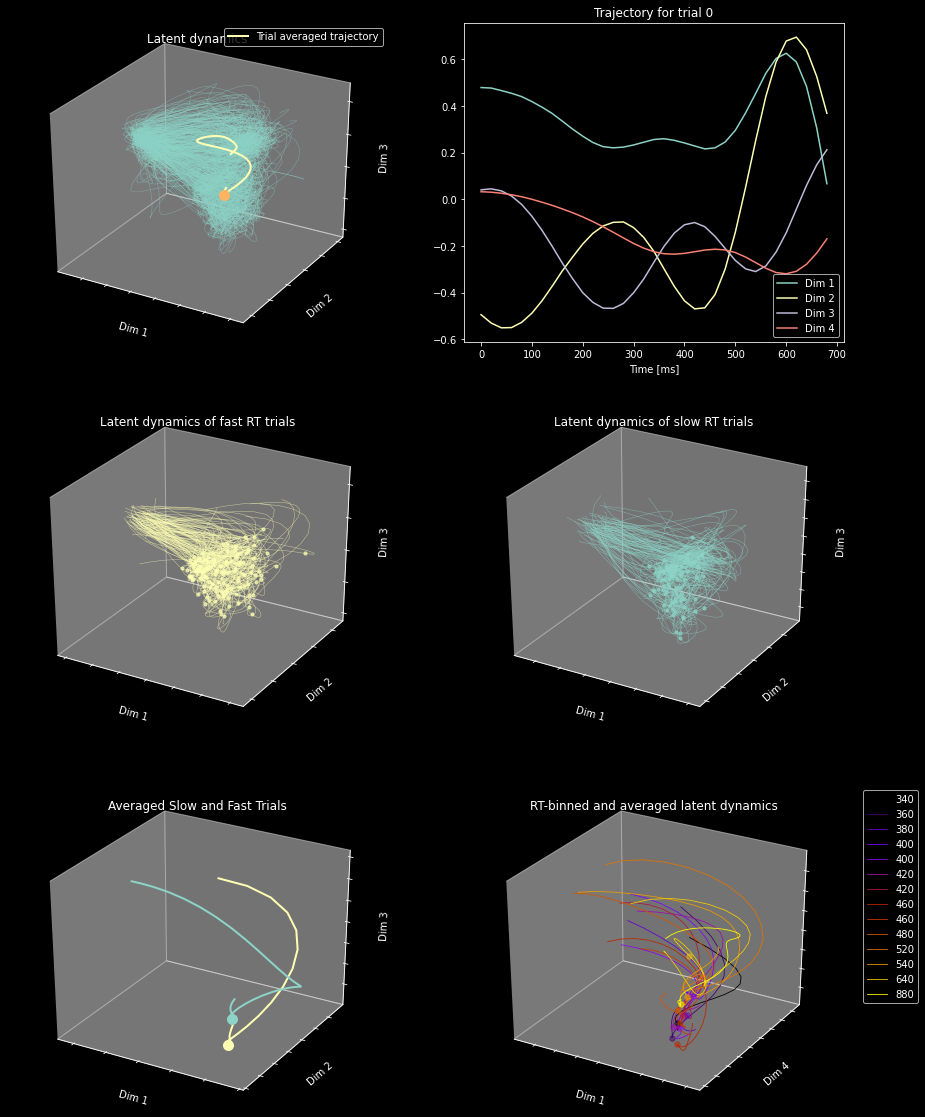

In [20]:
## setup

f = plt.figure(figsize=(15, 20))
ax1 = f.add_subplot(3, 2, 1, projection='3d')
ax2 = f.add_subplot(3, 2, 2)
ax3 = f.add_subplot(3, 2, 3, projection='3d')
ax4 = f.add_subplot(3, 2, 4, projection='3d')
ax5 = f.add_subplot(3, 2, 5, projection='3d')
ax6 = f.add_subplot(3, 2, 6, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

# checkerboard onset idx
checkOnIdx = np.where(times_trajectory==400)[0][0]

## plotting latent dynamics for all time points

ax1.set_title('Latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_zlabel('Dim 3')
ct = 0
for single_trial_trajectory in trajectories_all:
    ct +=1
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
    if ct>250:
        break
    
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.scatter(average_trajectory[0][checkOnIdx], average_trajectory[1][checkOnIdx], average_trajectory[2][checkOnIdx], s=100, c='C5')
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.zaxis.set_ticklabels([])
ax1.grid(False)
ax1.legend(loc='best')

## plotting trajectories for trial 0

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [ms]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('ms')

def mvmtIdx(trial_idx):
    m = behav['mvmt'][trial_idx]
    m = np.floor(m)
    for i in range(20):
        if m % 20 == 0:
            break
        m += 1
    try:
        t_idx = np.where(times_trajectory==m)[0][0]
    except:
        t_idx = len(times_trajectory)
    return t_idx

# get mvmt onset index
t_idx = mvmtIdx(trial_to_plot)

ax2.plot(times_trajectory[:t_idx], trajectories_all[0][0][:t_idx], c='C0', label="Dim 1")
ax2.plot(times_trajectory[:t_idx], trajectories_all[0][1][:t_idx], c='C1', label="Dim 2")
ax2.plot(times_trajectory[:t_idx], trajectories_all[0][2][:t_idx], c='C2', label="Dim 3")
ax2.plot(times_trajectory[:t_idx], trajectories_all[0][3][:t_idx], c='C3', label="Dim 4")
ax2.legend(loc='best')

## plotting Fast and Slow trials until movement onset

ax3.set_title('Latent dynamics of fast RT trials')
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')

ax4.set_title('Latent dynamics of slow RT trials')
ax4.set_xlabel('Dim 1')
ax4.set_ylabel('Dim 2')
ax4.set_zlabel('Dim 3')

ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.zaxis.set_ticklabels([])
ax3.grid(False)

ax4.xaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])
ax4.zaxis.set_ticklabels([])
ax4.grid(False)

trial_idx = 0
slowCt = 0 
fastCt = 0
for single_trial_trajectory in trajectories_all:
    
    if trial_idx in fastRTidx:
        fastCt += 1
        color_single_trial = 'C1'
        alpha_single_trial = 0.6
        
        # get mvmt onset index
        t_idx = mvmtIdx(trial_idx)

        ax3.plot(single_trial_trajectory[0][:t_idx], single_trial_trajectory[1][:t_idx], single_trial_trajectory[2][:t_idx], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
        ax3.scatter(single_trial_trajectory[0][checkOnIdx], single_trial_trajectory[1][checkOnIdx], single_trial_trajectory[2][checkOnIdx], s=10, c='C1', alpha=0.7)
        trial_idx += 1
        
    elif trial_idx in slowRTidx:
        slowCt += 1
        color_single_trial = 'C0'
        alpha_single_trial = 0.6
        
        # get mvmt onset index
        t_idx = mvmtIdx(trial_idx)

        ax4.plot(single_trial_trajectory[0][:t_idx], single_trial_trajectory[1][:t_idx], single_trial_trajectory[2][:t_idx], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
        ax4.scatter(single_trial_trajectory[0][checkOnIdx], single_trial_trajectory[1][checkOnIdx], single_trial_trajectory[2][checkOnIdx], s=10, c='C0', alpha=0.7)

        trial_idx += 1
        
    else:
        trial_idx += 1
        continue
    
    if slowCt>100 and fastCt>100:
        break

        
## plotting averaged Fast and Slow trials until movement onset

# get fast and slow trials
fastTrials = trajectories_all[fastRTidx]
slowTrials = trajectories_all[slowRTidx]
avgFastTrials = np.mean(fastTrials, axis=0)
avgSlowTrials = np.mean(slowTrials, axis=0)

# get avg time to mvmt onset for fast and slow trials
avgFastRT = np.mean(fastRTs['mvmt'])
avgSlowRT = np.mean(slowRTs['mvmt'])

# get time idx for avgFastRT and avgSlowRT
fastIdx = RT_idx(avgFastRT)
slowIdx = RT_idx(avgSlowRT)

ax5.plot(avgFastTrials[0][:fastIdx], avgFastTrials[1][:fastIdx], avgFastTrials[2][:fastIdx], '-', lw=linewidth_trial_average, c='C1', label='Fast')
ax5.scatter(avgFastTrials[0][checkOnIdx], avgFastTrials[1][checkOnIdx], avgFastTrials[2][checkOnIdx], s=100, c='C1')

ax5.plot(avgSlowTrials[0][:slowIdx], avgSlowTrials[1][:slowIdx], avgSlowTrials[2][:slowIdx], '-', lw=linewidth_trial_average, c='C0', label='Slow')
ax5.scatter(avgSlowTrials[0][checkOnIdx], avgSlowTrials[1][checkOnIdx], avgSlowTrials[2][checkOnIdx], s=100, c='C0')

ax5.set_title('Averaged Slow and Fast Trials')
ax5.set_xlabel('Dim 1')
ax5.set_ylabel('Dim 2')
ax5.set_zlabel('Dim 3')

ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.zaxis.set_ticklabels([])
ax5.grid(False)
        
## plot RT-binned dynamics

ax6.set_title('RT-binned and averaged latent dynamics')
ax6.set_xlabel('Dim 1')
ax6.set_ylabel('Dim 2')
ax6.set_ylabel('Dim 4')
ax6.xaxis.set_ticklabels([])
ax6.yaxis.set_ticklabels([])
ax6.zaxis.set_ticklabels([])
ax6.grid(False)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(avg_traj.keys()))]

ct = 0
for q, dim in avg_traj.items():
    ax6.plot(dim[0][:binMvmtIdx[q]], dim[1][:binMvmtIdx[q]], dim[3][:binMvmtIdx[q]], '-', color=colors[ct], lw=0.8 , label=str(int(times_trajectory[binMvmtIdx[q]])-400))
    ax6.scatter(dim[0][checkOnIdx], dim[1][checkOnIdx], dim[3][checkOnIdx], s=30, alpha=0.5, c=np.array(colors[ct][:3]).reshape(1,3))
    ct+=1
    
ax6.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

<IPython.core.display.Javascript object>


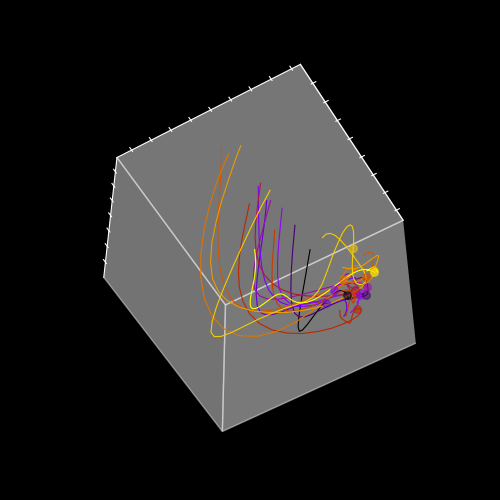

In [21]:
%matplotlib notebook

import scipy.io
import pandas as pd
from elephant.gpfa import GPFA
import numpy as np
import quantities as pq
import neo
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')


# ## plot interactive RT-binned dynamics

f = plt.figure(figsize=(5, 5))
ax6 = f.add_subplot(1,1,1, projection='3d')

# ax6.set_title('RT-binned and averaged latent dynamics')
# ax6.set_xlabel('Dim 1')
# ax6.set_ylabel('Dim 2')
# ax6.set_ylabel('Dim 4')
ax6.xaxis.set_ticklabels([])
ax6.yaxis.set_ticklabels([])
ax6.zaxis.set_ticklabels([])
ax6.grid(False)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(avg_traj.keys()))]

ct = 0
for q, dim in avg_traj.items():
    ax6.plot(dim[0][:binMvmtIdx[q]], dim[1][:binMvmtIdx[q]], dim[3][:binMvmtIdx[q]], '-', color=colors[ct], lw=0.8 , label=str(int(times_trajectory[binMvmtIdx[q]])-400))
    ax6.scatter(dim[0][checkOnIdx], dim[1][checkOnIdx], dim[3][checkOnIdx], s=30, alpha=0.5, c=np.array(colors[ct][:3]).reshape(1,3))
    ct+=1

# rotate the axes and update (doesn't work in Jupyter)
for angle in range(0, 360):
    ax6.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

plt.show()



### Cross Validation

Just checking out how it works

In [22]:
# from sklearn.model_selection import cross_val_score

# x_dims = [1, 2, 3, 4, 5]
# log_likelihoods = []
# for x_dim in x_dims:
#     gpfa_cv = GPFA(x_dim=x_dim)
#     # estimate the log-likelihood for the given dimensionality as the mean of the log-likelihoods from 3 cross-vailidation folds
#     cv_log_likelihoods = cross_val_score(gpfa_cv, st, cv=3, n_jobs=3, verbose=True)
#     log_likelihoods.append(np.mean(cv_log_likelihoods))

In [23]:
# f = plt.figure(figsize=(7, 5))
# plt.xlabel('Dimensionality of latent variables')
# plt.ylabel('Log-likelihood')
# plt.plot(x_dims, log_likelihoods, '.-')
# plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
# plt.tight_layout()
# plt.show()